In [1]:
import sys
import math
import random
from enum import Enum

import networkx as nx

from mesa import Agent, Model
from mesa.time import StagedActivation 
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid

from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from pyvis.network import Network

import math

from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.modules import ChartModule
from mesa.visualization.modules import NetworkModule
from mesa.visualization.modules import TextElement

import pandas as pd 
import numpy as np
import scipy.sparse as sps
import scipy as sp

import matplotlib.pyplot as plt

import multinetx as mx

# The following code is the full framework for the organized crime network model. Most of the model is built in such a way that one should be able to extend on it easily. 

## We start with some helper-functions and information/property dictionaries along with some comments about their functioning:

In [19]:
def make_dict(role_list, dict_type):
    'This function will create color and name dictionaries necessary for the functioning of the model'
    'It makes sure that each node will get the correct name and color'
    'Be aware when changing this function, as it is not very versatile (it is mostly hardcoded)'
    
    if dict_type == 'color':
        return_dict = {role_list[0]: 'red'} | dict.fromkeys(role_list[1], 'orange') | \
        dict.fromkeys(role_list[2], 'yellow') | dict.fromkeys(role_list[3], 'blue') | \
        dict.fromkeys(role_list[4], 'green') | dict.fromkeys(role_list[5], 'pink')
        
    elif dict_type == 'business_name':
        return_dict = {role_list[0]: 'kingpin_main'} | \
        {c:'kingpin_'+str(i) for i, c in enumerate(role_list[1])} | \
        {c:'orphan_'+str(i) for i, c in enumerate(role_list[2])} | \
        {c:'broker_'+str(i) for i, c in enumerate(role_list[3])} | \
        {c:'dealer_'+str(i) for i, c in enumerate(role_list[4])} | \
        {c:'coordinator_'+str(i) for i, c in enumerate(role_list[5])}
        
    elif dict_type == 'family_name':
        return_dict = {role_list[0]: 'father_main'} | \
        {c:'cousin_'+str(i) for i, c in enumerate(role_list[1])} | \
        {c:'brother_'+str(i) for i, c in enumerate(role_list[2])} | \
        {c:'friend_'+str(i) for i, c in enumerate(role_list[3])} | \
        {c:'driver_'+str(i) for i, c in enumerate(role_list[4])} | \
        {c:'contact_'+str(i) for i, c in enumerate(role_list[5])}
        
    elif dict_type == 'weight':
        return_dict = {role_list[0]: 100} | dict.fromkeys(role_list[1], 75) | \
        dict.fromkeys(role_list[2], 90) | dict.fromkeys(role_list[3], 50) | \
        dict.fromkeys(role_list[4], 40) | dict.fromkeys(role_list[5], 30)
        
    return return_dict

In [3]:
def add_edge_list(G, role_list1, role_list2, prob, role_color, role_weight, interconnected=False):
    'Function to add edges to a network according to the input parameters, indicating which roles should link,'
    'with what probability that edge should exist, what color the edge should have, and the edge weight'
    'The interconnected variable indicates whether the first list of nodes should be connected among themselves'
    
    # Regular edges
    for c in role_list1:
        edge_list = []
        for x in role_list2:
            
            # Create edge with probability 'prob' 
            if ((c is not x) and (random.uniform(0, 1) < prob)):
                
                # Prevent double edges 
                if (c, x) in G.edges():
                    G.remove_edge(c, x)
                elif (x, c) in G.edges():
                    G.remove_edge(x, c)
                edge_list += [(c, x)]
        
        # Add edges to network
        G.add_edges_from(edge_list, color=role_color, weight=role_weight)   
    
    # Interconnected edges (connections between first group)
    if interconnected:
        for c in role_list1:
            edge_list = []
            for x in role_list1:
                
                # No loop-edges (edge to oneself)
                if c is not x:
                    
                    # Prevent double edges
                    if (c, x) in G.edges():
                        G.remove_edge(c, x)
                    elif (x, c) in G.edges():
                        G.remove_edge(x, c)
                    edge_list += [(c, x)]
            
            # Add edges to network
            G.add_edges_from(edge_list, color=role_color, weight=role_weight)   

In [4]:
'The next dictionaries make it possible to manually insert edge-weights for both violence and trust based on'
'expert knowledge. Further down, there are functions that allow for randomisation'

# NOTE: when changing the trust/violence variables in the dictionary, note that right now the numbers are 50, but
#       they should be between 0 and 1, as that is the case for all other trust/violence variables as well

edge_violence_social = {'FAT_COU': 50, 'FAT_BRO': 50, 'FAT_FRI': 50, 'FAT_DRI': 50, 'FAT_CON': 50, \
                        'COU_FAT': 50, 'COU_BRO': 50, 'COU_FRI': 50, 'COU_DRI': 50, 'COU_CON': 50, \
                        'BRO_FAT': 50, 'BRO_COU': 50, 'BRO_FRI': 50, 'BRO_DRI': 50, 'BRO_CON': 50, \
                        'FRI_FAT': 50, 'FRI_COU': 50, 'FRI_BRO': 50, 'FRI_DRI': 50, 'FRI_CON': 50, \
                        'DRI_FAT': 50, 'DRI_COU': 50, 'DRI_BRO': 50, 'DRI_FRI': 50, 'DRI_CON': 50, \
                        'CON_FAT': 50, 'CON_COU': 50, 'CON_BRO': 50, 'CON_FRI': 50, 'CON_DRI': 50, \
                        'COU_COU': 50, 'BRO_BRO': 50, 'FRI_FRI': 50, 'DRI_DRI': 50, 'CON_CON': 50}

edge_trust_social = {'FAT_COU': 50, 'FAT_BRO': 50, 'FAT_FRI': 50, 'FAT_DRI': 50, 'FAT_CON': 50, \
                     'COU_FAT': 50, 'COU_BRO': 50, 'COU_FRI': 50, 'COU_DRI': 50, 'COU_CON': 50, \
                     'BRO_FAT': 50, 'BRO_COU': 50, 'BRO_FRI': 50, 'BRO_DRI': 50, 'BRO_CON': 50, \
                     'FRI_FAT': 50, 'FRI_COU': 50, 'FRI_BRO': 50, 'FRI_DRI': 50, 'FRI_CON': 50, \
                     'DRI_FAT': 50, 'DRI_COU': 50, 'DRI_BRO': 50, 'DRI_FRI': 50, 'DRI_CON': 50, \
                     'CON_FAT': 50, 'CON_COU': 50, 'CON_BRO': 50, 'CON_FRI': 50, 'CON_DRI': 50, \
                     'COU_COU': 50, 'BRO_BRO': 100, 'FRI_FRI': 50, 'DRI_DRI': 50, 'CON_CON': 50}

edge_trust_business = {'KIM_KIP': 50, 'KIM_ORP': 50, 'KIM_BRK': 50, 'KIM_DEA': 50, 'KIM_COR': 50, \
                     'KIP_KIM': 50, 'KIP_ORP': 50, 'KIP_BRK': 50, 'KIP_DEA': 50, 'KIP_COR': 50, \
                     'ORP_KIM': 50, 'ORP_KIP': 50, 'ORP_BRK': 50, 'ORP_DEA': 50, 'ORP_COR': 50, \
                     'BRK_KIM': 50, 'BRK_KIP': 50, 'BRK_ORP': 50, 'BRK_DEA': 50, 'BRK_COR': 50, \
                     'DEA_KIM': 50, 'DEA_KIP': 50, 'DEA_ORP': 50, 'DEA_BRK': 50, 'DEA_COR': 50, \
                     'COR_KIM': 50, 'COR_KIP': 50, 'COR_ORP': 50, 'COR_BRK': 50, 'COR_DEA': 50, \
                     'KIP_KIP': 50, 'ORP_ORP': 50, 'BRK_BRK': 50, 'DEA_DEA': 50, 'COR_COR': 50}

edge_violence_business = {'KIM_KIP': 50, 'KIM_ORP': 50, 'KIM_BRK': 50, 'KIM_DEA': 50, 'KIM_COR': 50, \
                     'KIP_KIM': 50, 'KIP_ORP': 50, 'KIP_BRK': 50, 'KIP_DEA': 50, 'KIP_COR': 50, \
                     'ORP_KIM': 50, 'ORP_KIP': 50, 'ORP_BRK': 50, 'ORP_DEA': 50, 'ORP_COR': 50, \
                     'BRK_KIM': 50, 'BRK_KIP': 50, 'BRK_ORP': 50, 'BRK_DEA': 50, 'BRK_COR': 50, \
                     'DEA_KIM': 50, 'DEA_KIP': 50, 'DEA_ORP': 50, 'DEA_BRK': 50, 'DEA_COR': 50, \
                     'COR_KIM': 50, 'COR_KIP': 50, 'COR_ORP': 50, 'COR_BRK': 50, 'COR_DEA': 50, \
                     'KIP_KIP': 50, 'ORP_ORP': 50, 'BRK_BRK': 50, 'DEA_DEA': 50, 'COR_COR': 50}
      

def get_violtrust(edge_ID):
    'This function returns fixed violence and trust variables for the given input edge'
    viol = edge_violence_social[edge_ID]
    trus = edge_trust_social[edge_ID]
    return viol, trus

def get_semirandom_violtrust(edge_ID):
    'This function returns semi-random violence and trust variables for the given input edge'
    ran_change_viol = random.uniform(-0.25, 0.25)
    ran_change_trust = random.uniform(-0.25, 0.25)
    viol = edge_violence_business[edge_ID] 
    trus = edge_trust_business[edge_ID] 
    final_viol = max(min((viol + ran_change_viol), 1), 0)
    final_trust = max(min((trus + ran_change_trust), 1), 0)
    return final_viol, final_trust
    
def get_edgeID(G, element, name_dict):
    'This function returns an edge ID for a given edge'
    role_1 = name_dict[element[0]]
    role_2 = name_dict[element[1]]
    string_1 = get_role_char(role_1)
    string_2 = get_role_char(role_2)
    return string_1 + '_' + string_2
    
def get_role_char(role):
    'This function returns an abbreviation indicating the group that the given role belongs to'
    'It is used to create edge IDs'
    'The abbreviation should always be 3-lettered, see next function'
    if 'father' in role:
        return 'FAT'
    elif 'cousin' in role:
        return 'COU'
    elif 'brother' in role:
        return 'BRO'
    elif 'friend' in role:
        return 'FRI'
    elif 'driver' in role:
        return 'DRI'
    elif 'contact' in role:
        return 'CON'
    elif 'kingpin_main' in role:
        return 'KIM'
    elif 'kingpin' in role:
        return 'KIP'
    elif 'orphan' in role:
        return 'ORP'
    elif 'broker' in role:
        return 'BRK'
    elif 'dealer' in role:
        return 'DEA'
    elif 'coordinator' in role:
        return 'COR'
    else:
        return 'NONE'
    
def change_ID(old_string, kim_num, edge_nums):
    'This function is used to rename all links of the new kingpin to an appropriate one'
    'Be aware: the lengths of the abbreviations are assumed to always be 3: if not, wrong edge IDs will be created'
    if kim_num == edge_nums[0]:
        return 'KIM' + old_string[4:7]
    elif kim_num == edge_nums[1]:
        return old_string[0:4] + 'KIM'
    else:
        return 'NONE'

## The next function creates the networks that are used in the model. It makes use of the helper functions and dictionaries to set up the two networks. For now, only business and social are used, but one can extend with more networks.

In [5]:
def create_networks(networks, N=30):
    'Function to create the networks involved; for now, business and social'
    
    # The variable that eventually will be retured by the function, here the created networks will be stored
    network_list = []
    
    # Create IDs for agents
    shuffled = random.sample(range(0, N), N)

    # Set roles business
    kingpin_main = shuffled[0]
    kingpin_list = shuffled[1:4]
    orphan_list = shuffled[4:8]
    broker_list = shuffled[8:16]
    dealer_list = shuffled[16:23]
    coordinator_list = shuffled[23:N]
    
    'Uncomment next line if business roles are not tied to social roles.'
#     shuffled = random.sample(range(0, N), N)
    
    # Set roles family/social
    father_main = shuffled[0]
    cousin_list = shuffled[1:4]
    brother_list = shuffled[4:8]
    friend_list = shuffled[8:16]
    driver_list = shuffled[16:23]
    contact_list = shuffled[23:N]
    
    # Create business/social role lists
    business_role_list = [kingpin_main, kingpin_list, orphan_list, broker_list, dealer_list, coordinator_list]
    family_role_list = [father_main, cousin_list, brother_list, friend_list, driver_list, contact_list]
    
    # Make dictionaries for attributes
    business_color_dict = make_dict(business_role_list, 'color')
    family_color_dict = make_dict(family_role_list, 'color')
    business_name_dict = make_dict(business_role_list, 'business_name')
    family_name_dict = make_dict(family_role_list, 'family_name')
    business_weight_dict = make_dict(business_role_list, 'weight')
    family_weight_dict = make_dict(family_role_list, 'weight')
        
    # Create each network
    for name in networks:
        
        # Start with empty network
        G = nx.empty_graph(N)
        
        # Set names, colours and weights
        nx.set_node_attributes(G, business_name_dict, "business_name")
        nx.set_node_attributes(G, family_name_dict, "family_name")
        nx.set_node_attributes(G, business_color_dict, "business_color")
        nx.set_node_attributes(G, family_color_dict, "family_color")
        nx.set_node_attributes(G, business_weight_dict, "business_weight")
        nx.set_node_attributes(G, family_weight_dict, "family_weight")
        
        # For business network
        if name == 'business':
            
            # Add edge lists including weight and colours
            add_edge_list(G, coordinator_list, G.nodes(), 0.1, 'pink', 30) 
            add_edge_list(G, dealer_list, G.nodes(), (1/6), 'green', 50) 
            add_edge_list(G, broker_list, G.nodes(), 0.25, 'blue', 70) 
            add_edge_list(G, orphan_list, G.nodes(), (1/3), 'yellow', 80, True) 
            add_edge_list(G, kingpin_list, G.nodes(), 0.25, 'orange', 100)
            add_edge_list(G, [kingpin_main], G.nodes(), 1, 'red', 100)
            
            # Assign (semi-)random values to variables and set edge IDs
            violence_dict = dict()
            trust_dict = dict()
            usefulness_dict = dict()
            edgeID_dict = dict()
            for element in G.edges():
                edge_ID = get_edgeID(G, element, business_name_dict)
                edgeID_dict[element] = edge_ID
                viol, trus = get_semirandom_violtrust(edge_ID)
                violence_dict[element] = viol
                trust_dict[element] = trus
                usefulness_dict[element] = random.uniform(0.3,1)
            nx.set_edge_attributes(G, violence_dict, name="edge_violence")
            nx.set_edge_attributes(G, trust_dict, name="edge_trust")
            nx.set_edge_attributes(G, usefulness_dict, name="edge_usefulness")
            nx.set_edge_attributes(G, edgeID_dict, name="edge_ID")

            # Append network for returning
            network_list.append(G)

            # Get node and edge colours for drawing
            business_values = [business_color_dict.get(node, 'k') for node in G.nodes()]
            edge_colors = nx.get_edge_attributes(G,'color').values()
            
            # Draw network
            nx.draw(G, with_labels=True, edge_color=edge_colors, node_color=business_values)
            plt.show()
            
        # For social network
        if name == 'social':
            
            # Add edge lists including weight and colours
            add_edge_list(G, driver_list, contact_list, 1, 'green', 50, True) 
            add_edge_list(G, friend_list, driver_list, 1, 'blue', 70, True) 
            add_edge_list(G, brother_list, friend_list, 1, 'yellow', 80, True) 
            add_edge_list(G, cousin_list, friend_list, 1, 'orange', 70, True) 
            add_edge_list(G, [father_main], G.nodes(), 1, 'red', 100, True) 
            
            # Assign values to variables and set edge IDs
            violence_dict = dict()
            trust_dict = dict()
            edgeID_dict = dict()
            for element in G.edges():
                edge_ID = get_edgeID(G, element, family_name_dict)
                edgeID_dict[element] = edge_ID
                viol, trus = get_violtrust(edge_ID)
                violence_dict[element] = viol
                trust_dict[element] = trus   
            nx.set_edge_attributes(G, violence_dict, name="edge_violence")
            nx.set_edge_attributes(G, trust_dict, name="edge_trust")
            nx.set_edge_attributes(G, edgeID_dict, name="edge_ID")

            # Append network for returning
            network_list.append(G)           
                
            # Get node and edge colours for drawing
            family_colors = nx.get_edge_attributes(G,'color').values()
            family_values = [family_color_dict.get(node, 'k') for node in G.nodes()]

            # Draw network
            nx.draw(G, with_labels=True, edge_color=family_colors, node_color=family_values)
            plt.show()

    return network_list

## Below, we have the actual model. First, we create the Agents class for each individual node. Then, we create the model, that combines all functionalities of the code above and collects the data.

In [6]:
class Agents(Agent):
    'This class creates entities to represent agents in the model'
    'Each agent is directly tied to a node in the networks'
    'This class mainly stores some basic agent info that could be very useful when extending the model'
    def __init__ (self, unique_ID, model):
        # Initialise with node number as ID and random values for the variables
        super(). __init__(unique_ID, model)
        self.ID = unique_ID
        self.violence = random.uniform(0,1)
        self.trust = random.uniform(0,1)
        self.usefulness = random.uniform(0.3,1)
        if random.uniform(0,1) < 0.9:
            self.gen = "m"
        else:
            self.gen = "f"
    
    # The step/stages functions are set up but not yet used in the model. This is because for now,
    # the agents do not have individual behaviour. But setting it up this way, it should now be easily
    # implementable when needed.
    def step(self):
        print('test')   
    def stage1(self):
        print('stage1')    
    def stage2(self):
        print('stage2')     
    def stage3(self):
        print('stage3')    
    def stage4(self):
        print('stage4')

In [7]:
class ReplacementModel(Model):
    'This class is the working machine of the model'
    'More detailed function specifics can be found at each corresponding function'
    
    def __init__ (self, phase='start'):
        'This is the initialisation function: it is only called once, namely when a new model is created'
        'Each time it initialises, it creates 2 random networks and stores the relevant information'
        'This function initialises in the starting phase automatically, however one could manually change this'
        
        # Staged activation; means that agents first all perform stage 1 before any agent starts stage 2
        # Not yet used but could be very useful when extending the model
        self.schedule = StagedActivation(self, stage_list = ['stage1', 'stage2', 'stage3', 'stage4'])
        
        # Create and store networks
        self.nets = create_networks(['business', 'social'])
        self.business = self.nets[0]
        self.social = self.nets[1]
        
        # Create model variables (-1 for variables that are set later)
        self.phase = phase
        self.steps = 0
        self.interval = -1
        self.draw = -1
        self.violence = -1
        self.trust = -1
        self.usefulness = -1
        self.potential = -1
        self.worth_duration = 0
        
        # Store information dictionaries
        self.business_name_dict = nx.get_node_attributes(self.business,'business_name')
        self.family_name_dict = nx.get_node_attributes(self.social,'family_name')
        self.business_color_dict = nx.get_node_attributes(self.business,'business_color')
        self.family_color_dict = nx.get_node_attributes(self.social,'family_color')
        self.business_edge_colors = nx.get_edge_attributes(self.business,'color')
        self.family_edge_colors = nx.get_edge_attributes(self.social,'color')
        self.business_trust_edges = nx.get_edge_attributes(self.business, 'edge_trust')
        self.business_violence_edges = nx.get_edge_attributes(self.business, 'edge_violence')
        self.business_usefulness_edges = nx.get_edge_attributes(self.business, 'edge_usefulness')
        self.business_edgeIDs = nx.get_edge_attributes(self.business, 'edge_ID')
        self.family_trust_edges = nx.get_edge_attributes(self.social, 'edge_trust')
        self.family_violence_edges = nx.get_edge_attributes(self.social, 'edge_violence')
        self.family_edgeIDs = nx.get_edge_attributes(self.social, 'edge_ID')
        
        # Store a list containing the orphans and give a threshold for their trust
        self.orphans = [key for key, value in self.business_name_dict.items() if 'orphan' in value]
        self.orphan_trust_threshold = 0.75
        
        # Set a separate variable storing the number of the main kingpin node
        self.kingpin_main = [key for key, value in self.business_name_dict.items() if 'kingpin_main' == value][0]

        # Add all nodes to schedule
        for node in self.business:
            a = Agents(node, self)
            self.schedule.add(a)
        
        # Data Collection
        'The data collecter is important for the analyses, here we can store any step-by-step'
        'information that is being produced by the model. Then, after running, we can retrieve'
        'the datacollector. For now, only the phases and names are stored, but one can easily extend.'
        self.datacollector = DataCollector(
            model_reporters={"Phases": 'phase',
                            "Names": 'business_name_dict'})
        
    def remove_king(self):
        'Function that removes the current kingpin'
        self.update_dicts()
        for agent in model.schedule.agents:
            if self.business_name_dict[agent.ID] == 'kingpin_main':
                self.business.remove_node(agent.ID)
                self.social.remove_node(agent.ID)
                self.schedule.remove(agent)
                self.update_dicts()
                self.phase = 'removed'
                print('Kingpin has been removed at step: ', self.steps)
                
    def remove_exiled_agents(self):
        'Function that removes agents that have no active ties (edges) to other agents'
        'This function has no use after the addition and implementation of "replace_exiled_agents"'
        'The function is kept intact in case agents are to be removed from the model in a later stage'
        for agent in model.schedule.agents:
            
            # If no edges in business network
            if len([edge for edge in self.business.edges() if agent.ID in edge]) == 0:
                
                # If orphan, also remove from orphan list
                if agent.ID in self.orphans:
                    self.orphans.remove(agent.ID)
                
                # Remove agent completely
                self.business.remove_node(agent.ID)
                self.social.remove_node(agent.ID)
                self.schedule.remove(agent)
        
        self.update_dicts()
                
    def replace_exiled_agents(self):
        'Function that replaces agents that have no active ties (edges) with agents of the same role'
        
        # Place agentIDs in role-specific lists
        coordinator_list = [k for k in model.business_name_dict if 'coordinator' in model.business_name_dict[k]]
        dealer_list = [k for k in model.business_name_dict if 'dealer' in model.business_name_dict[k]]
        broker_list = [k for k in model.business_name_dict if 'broker' in model.business_name_dict[k]]
        orphan_list = [k for k in model.business_name_dict if 'orphan' in model.business_name_dict[k]]
        kingpin_list = [k for k in model.business_name_dict if 'kingpin' in model.business_name_dict[k] \
                    and model.business_name_dict[k] != 'kingpin_main']
        kingpin_main = [k for k in model.business_name_dict if 'kingpin_main' == model.business_name_dict[k]]
        
        for agent in model.schedule.agents:
            
            # If no edges in business network
            if len([edge for edge in self.business.edges() if agent.ID in edge]) == 0:
                
                add_edge_list(self.business, coordinator_list, [agent.ID], 0.1, 'pink', 30) 
                add_edge_list(self.business, dealer_list, [agent.ID], (1/6), 'green', 50) 
                add_edge_list(self.business, broker_list, [agent.ID], 0.25, 'blue', 70) 
                add_edge_list(self.business, orphan_list, [agent.ID], (1/3), 'yellow', 80, True) 
                add_edge_list(self.business, kingpin_list, [agent.ID], 0.25, 'orange', 100)
                add_edge_list(self.business, [kingpin_main], [agent.ID], 1, 'red', 100)

        self.update_dicts()
 
    def connect_node(self):
        'Function to find best potential replacement'
        self.update_dicts()
        best_trust = 0
        best_potential = -1
        
        # For each agent
        for agent in model.schedule.agents:
            
    # Uncomment the line below to let orphans only consider 'potential kingpins'
#             if 'kingpin' in self.business_name_dict[agent.ID]:

            # Check trust of agent among orphans
            trust_avg = self.check_average_orphan_trust(agent.ID)
            
            # If better than up-to-now best, set as up-to-now best
            if trust_avg > best_trust:
                best_trust = trust_avg
                best_potential = agent
        
        # Set variables to best potential replacement and change the phase
        self.potential = best_potential.ID
        self.link_orphans(best_potential)
        self.update_dicts()
        self.phase = 'chosen'
        print('Potential kingpin has been chosen at step: ', self.steps-1)
    
    def link_orphans(self, agent):
        'Function to link the potential new kingpin to the orphans'
        self.update_dicts()
        
        # Add edges
        add_edge_list(self.business, [agent.ID], self.orphans, 1, 'lightblue', 70)
        
        # Create semi_random trust values
        for o in self.orphans:
            if (agent.ID, o) not in self.business_trust_edges and (o, agent.ID) not in self.business_trust_edges:
                self.business_trust_edges[(o, agent.ID)] = random.uniform(0.35,0.65)
                
        # Set values
        nx.set_edge_attributes(self.business, self.business_trust_edges, 'edge_trust')
        self.update_dicts()
        
    def reduce_orphan_trust(self, agent):
        'Function to reduce the trust that the orphans have in the given agent'
        for o in self.orphans:
            if (agent, o) in self.business_trust_edges:
                new_trust = self.business_trust_edges[(agent, o)] - 0.1
                self.business_trust_edges[(agent, o)] = max(0, new_trust)
            elif (o, agent) in self.business_trust_edges:
                new_trust = self.business_trust_edges[(o, agent)] - 0.1
                self.business_trust_edges[(o, agent)] = max(0, new_trust)
                   
    def pick_kingpin(self):
        'In this function it is decided whether the potential new kingpin is picked or not'
        self.update_dicts()
        trust_avg = self.check_average_orphan_trust(self.potential)
        if trust_avg > self.orphan_trust_threshold:
            self.phase = 'picked'
            self.update_links()
            self.draw = self.steps + 1
            self.worth_duration = 0
            self.orphan_trust_threshold = 0.75
            print('Kingpin has been picked at step: ', self.steps)
        else:
            self.phase = 'removed+'
            self.reduce_orphan_trust(self.potential)
            self.orphan_trust_threshold -= 0.05

            
    def update_links(self):
        'This function makes the potential kingpin that got picked, into the actual kingpin'
        'It sets and resets some model variables, and updates all relevant node/edge information'
        'It also increases the trust that agents have in the kingpin'
        self.update_dicts()

        # Officialise the new kingpin, reset potential, set new node attributes
        self.kingpin_main = self.potential
        self.potential = -1
        self.business_name_dict[self.kingpin_main] = 'kingpin_main'
        self.business_color_dict[self.kingpin_main] = 'red'
        self.family_color_dict[self.kingpin_main] = 'red'
        nx.set_node_attributes(self.business, self.business_name_dict, "business_name")
        nx.set_node_attributes(self.business, self.business_color_dict, "business_color")
        nx.set_node_attributes(self.social, self.family_color_dict, "family_color")
        
        # Set new edges including new color
        add_edge_list(self.business, [self.kingpin_main], self.business.nodes(), 1, 'red', 70)
        add_edge_list(self.social, [self.kingpin_main], self.social.nodes(), 1, 'red', 70)
        
        # Change edge IDs
        for edge in self.business.edges():
            if self.kingpin_main in edge:
                if edge in self.business_edgeIDs:
                    self.business_edgeIDs[edge] = change_ID(self.business_edgeIDs[edge], self.kingpin_main, edge)
        
        # For all agents except kingpin
        for node in self.business.nodes():
            if self.kingpin_main is not node:
                
                # Increase trust in kingpin
                if (self.kingpin_main, node) in self.business_trust_edges:
                    self.business_trust_edges[(self.kingpin_main, node)] = \
                    self.business_trust_edges[(self.kingpin_main, node)] * 1.2
                elif (node, self.kingpin_main) in self.business_trust_edges:
                    self.business_trust_edges[(node, self.kingpin_main)] = \
                    self.business_trust_edges[(node, self.kingpin_main)] * 1.2
                    
                # Or set new trust if non-existant before
                else:
                    self.business_trust_edges[(self.kingpin_main, node)] = random.uniform(0.3, 0.65)
                
                # If not present, create violence edge with kingpin based on average between the two
                if ((self.kingpin_main, node) not in self.business_violence_edges) \
                and ((node, self.kingpin_main) not in self.business_violence_edges):
                    self.business_violence_edges[(self.kingpin_main, node)] = \
                    self.get_new_violence(self.kingpin_main, node)   
        
        # Set new values
        nx.set_edge_attributes(self.business, self.business_trust_edges, 'edge_trust')
        nx.set_edge_attributes(self.business, self.business_violence_edges, 'edge_violence')
        nx.set_edge_attributes(self.business, self.business_edgeIDs, 'edge_ID')
        self.update_dicts()
             
    def get_new_violence(self, kingpin, node):
        'Function that calculates the average violence between two agents'
        'Until now only used to calculate violence values for new edges of the recently picked kingpin'
        for a in self.schedule.agents:
            if a.ID == kingpin:
                kin_viol = a.violence
            elif a.ID == node:
                nod_viol = a.violence
        return (kin_viol + nod_viol) / 2
            
    def check_worthy(self):
        'Function that checks whether the kingpin is still considered worthy by the orphans'
        self.update_dicts()
        trust_avg = self.check_average_orphan_trust(self.kingpin_main)
        if trust_avg < 0.3:
            self.remove_king()
        else: 
            self.worth_duration += 1
        self.update_dicts()

    def check_violence(self):
        'Function to check the average violence of all agents'
        violence = 0
        for agent in self.schedule.agents:
            violence += agent.violence
        violence_average = violence / len(self.schedule.agents)
        self.violence = violence_average
        
    def check_trust(self):
        'Function to check the average trust of all agents'
        trust = 0
        for agent in self.schedule.agents:
            trust += agent.trust
        trust_average = trust / len(self.schedule.agents)
        self.trust = trust_average
        
    def check_usefulness(self):
        'Function to check the average usefulness of all agents'
        usefulness = 0
        for agent in self.schedule.agents:
            usefulness += agent.usefulness
        usefulness_average = usefulness / len(self.schedule.agents)
        self.usefulness = usefulness_average
        
    def check_average_orphan_trust(self, agent):
        'Function that checks the average trust of the orphans in the given agent'
        trust_level = 0
        for o in self.orphans:
            if (agent, o) in self.business_trust_edges:
                trust_level += self.business_trust_edges[(agent, o)]
            elif (o, agent) in self.business_trust_edges:
                trust_level += self.business_trust_edges[(o, agent)]
        trust_avg = trust_level / len(self.orphans)
        return trust_avg

    def change_edge_trust(self):
        'Function that changes the trust levels of the agents in the business network'
        'In principal, this function is only used when the kingpin just got removed'
        self.update_dicts()
        for edge in self.business.edges(): 
            
            # This string is made so that name checking works one-direction
            name_string = self.family_name_dict[edge[0]] + self.family_name_dict[edge[1]]
        
            # Change edge trust according to the kind of connection (what roles the agents have)
            if 'brother' in self.family_name_dict[edge[0]] and 'brother' in self.family_name_dict[edge[1]]:
                self.business_trust_edges[edge] = min((self.business_trust_edges[edge] * 1.3), 1)               
            elif 'cousin' in name_string and 'friend' in name_string:
                self.business_trust_edges[edge] = self.business_trust_edges[edge] * 1.7
            elif 'brother' in name_string and 'friend' in name_string:
                self.business_trust_edges[edge] = self.business_trust_edges[edge] * 1.4
            elif 'driver' in name_string and 'contact' in name_string:
                self.business_trust_edges[edge] = self.business_trust_edges[edge] * 1.2
            elif 'brother' in name_string and 'driver' in name_string:
                self.business_trust_edges[edge] = self.business_trust_edges[edge] * 1.2

            # Remove if trust among two agents is too low
            if self.business_trust_edges[edge] < 0.5:
                del self.business_trust_edges[edge]
                self.business.remove_edge(edge[0], edge[1])
            
            # Increase if trust among two agents is exceptionally high
            elif self.business_trust_edges[edge] > 0.8:
                self.business_trust_edges[edge] = min((self.business_trust_edges[edge] * 1.005), 1)
                
        # Update phase and attributes
        self.phase = 'removed+'
        nx.set_edge_attributes(self.business, self.business_trust_edges, 'edge_trust')
        self.update_dicts()

    def ran_change_edges(self):
        'Function that randomly changes the trust and violence between agents'
        'Works on both a business and social level'
        self.update_dicts()
        
        business_change_var = 0.01
        social_change_var = 0.005
        
        # Business network
        for edge in self.business.edges():
            
            # Get a different random value for every edge and for trust and violence
            ran_trust = random.choice([-business_change_var, business_change_var])
            ran_violence = random.choice([-business_change_var, business_change_var])
            
            # Remove for low trust, else add the random change but keep between 0 and 1
            if edge in self.business_trust_edges:
                if self.business_trust_edges[edge] < 0.15:
                    del self.business_trust_edges[edge]
                    self.business.remove_edge(edge[0], edge[1])
                else:
                    new_trust = max(min((self.business_trust_edges[edge] + ran_trust), 1), 0)
                    self.business_trust_edges[edge] = new_trust
            
            # All edges should be present in the business trust edge dict, but in case not: 
            else:
                new_trust = random.uniform(0, 1)
                self.business_trust_edges[edge] = new_trust
                
            # Change violence
            if edge in self.business_violence_edges:
                new_violence = max(min((self.business_violence_edges[edge] + ran_violence), 1), 0)
            else:
                new_violence = random.uniform(0, 1) 
            self.business_violence_edges[edge] = new_violence
            
        # Social network
        for edge in self.social.edges():
            ran_trust = random.choice([-social_change_var, social_change_var])
            ran_violence = random.choice([-social_change_var, social_change_var])
            if edge in self.family_trust_edges:
                new_trust = max(min((self.family_trust_edges[edge] + ran_trust), 1), 0)
            else:
                new_trust = random.uniform(0, 1)
            if edge in self.family_violence_edges:
                new_violence = max(min((self.family_violence_edges[edge] + ran_violence), 1), 0)
            else:
                new_violence = random.uniform(0, 1) 
            self.family_trust_edges[edge] = new_trust
            self.family_violence_edges[edge] = new_violence
        
        # Update edges in networks
        nx.set_edge_attributes(self.business, self.business_trust_edges, 'edge_trust')
        nx.set_edge_attributes(self.business, self.business_violence_edges, 'edge_violence')
        nx.set_edge_attributes(self.social, self.family_trust_edges, 'edge_trust')
        nx.set_edge_attributes(self.social, self.family_violence_edges, 'edge_violence')
        self.update_dicts()
    
    def update_dicts(self):
        'Function to update information dictionaries in the model'
        'The function retrieves the info from the networks'
        'The dictionaries can then be used for various applications'
        self.business_name_dict = nx.get_node_attributes(self.business,'business_name')
        self.family_name_dict = nx.get_node_attributes(self.social,'family_name')
        self.business_color_dict = nx.get_node_attributes(self.business,'business_color')
        self.family_color_dict = nx.get_node_attributes(self.social,'family_color')
        self.business_edge_colors = nx.get_edge_attributes(self.business,'color')
        self.family_edge_colors = nx.get_edge_attributes(self.social,'color')
        self.business_trust_edges = nx.get_edge_attributes(self.business, 'edge_trust')
        self.business_violence_edges = nx.get_edge_attributes(self.business, 'edge_violence')
        self.business_usefulness_edges = nx.get_edge_attributes(self.business, 'edge_usefulness')
        self.business_edgeIDs = nx.get_edge_attributes(self.business, 'edge_ID')
        self.family_trust_edges = nx.get_edge_attributes(self.social, 'edge_trust')
        self.family_violence_edges = nx.get_edge_attributes(self.social, 'edge_violence')
        self.family_edgeIDs = nx.get_edge_attributes(self.social, 'edge_ID')

    def draw_networks(self):
        'Function to draw the networks involved'
        self.update_dicts() 

        # Business network
        nx.draw(self.business, with_labels=True, edge_color=self.business_edge_colors.values(), \
                node_color=self.business_color_dict.values())
        plt.show()
        
        # Social network
        nx.draw(self.social, with_labels=True, edge_color=self.family_edge_colors.values(), \
                node_color=self.family_color_dict.values())
        plt.show()
        
        
    def step(self):
        'This function is the "engine" of the model'
        'After the model is created, one can call this step function to let the model run'
        'Some of the functionalities of the model will be performed every step'
        'For other functions it depends on the phase whether it will be performed'
        
        # Collect data at start of each step
        self.datacollector.collect(self)
        
        # Remove agents that have no edges with other agents anymore
        self.replace_exiled_agents()
        
        # Stop execution if no more agents present (after recent changes, this should not be necessary anymore)
        if (len(self.schedule.agents)) == 0 or (len(self.orphans) == 0):
            sys.exit('No more agents in the model')
    
        # Randomly change trust and violence edges at each step, and update averages
        self.ran_change_edges()
        self.check_violence()
        self.check_trust()
        self.check_usefulness()
        
        # Set interval variable
        self.interval = random.randrange(self.steps, self.steps + 5)
        
        # Remove king if at start
        if self.phase == 'start':
            self.remove_king()
            
        # If just removed, update ties accordingly and draw the network
        elif self.phase == 'removed':
            self.change_edge_trust()
            self.draw_networks()
        
        # If removed, choose best potential kingpin (self.interval assures that some arbitrary time passes)
        elif (self.phase == 'removed+') and (self.steps == self.interval):
            self.connect_node()
            
        # If chosen and some more arbitrary time has passed, decide whether or not to pick the kingpin
        elif (self.phase == 'chosen') and (self.steps == self.interval):
            self.pick_kingpin()
            
        # If kingpin is picked, decide whether the kingpin is still worthy (remove if not)
        elif (self.phase == 'picked'):
            
            # Draw network if just picked
            if (self.steps == self.draw):
                self.draw_networks()
                
            self.check_worthy()
#             if self.worth_duration > 29:
#                 print('we are here')
#                 sys.exit('New kingpin has been deemed worthy for 30 days')

        # Keep track of the steps
        self.steps += 1

## Finally, we can let the model run. Running the model gives some printed output and the lay-out of both networks in simple form. Most data is actually collected with the datacollector, so we'll demonstrate the use of that below.

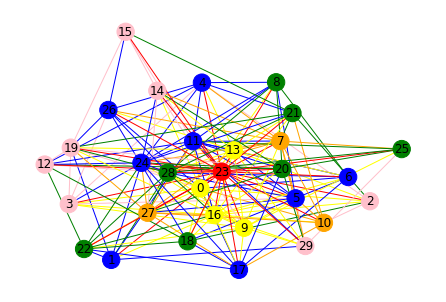

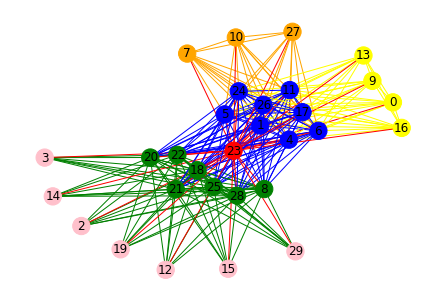

Kingpin has been removed at step:  0


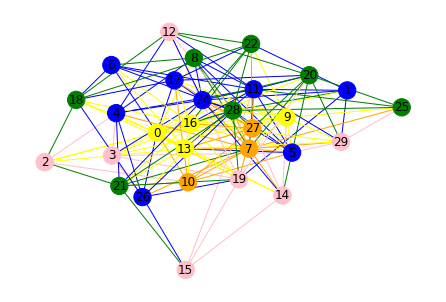

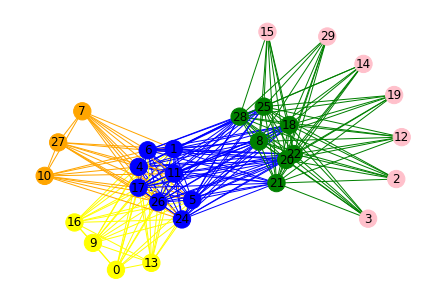

Potential kingpin has been chosen at step:  2
Kingpin has been picked at step:  5


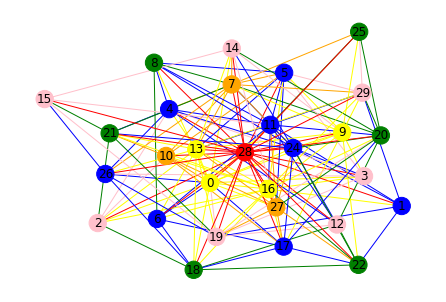

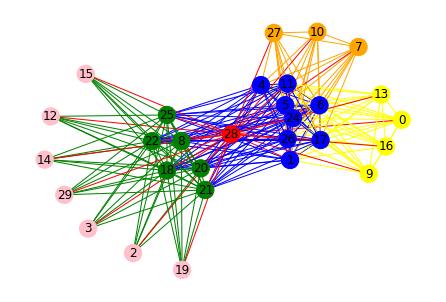

New kingpin has been deemed worthy for 30 days


In [22]:
'This is were the model is actually created'

# First, we initialise the model:
model = ReplacementModel()

# We set the max amount of steps, and a threshold for minimal 'worthy' days: 
steps_to_run = 1000
min_worthy_days = 30

# Then, we let the model run, and we can check from the prints how it develops
for i in range(steps_to_run):
    if model.worth_duration < min_worthy_days:
        model.step()
    else:
        print('New kingpin has been deemed worthy for 30 days')
        break

In [23]:
'With the datacollector, we can trackback step by step what phase the model was in along with its properties'
'For now, it only collects the names, but it can easily be extended as shown at the datacollector part of the code'
gini = model.datacollector.get_model_vars_dataframe()
gini[:50]

,Phases,Names
0,start,"{0: 'orphan_0', 1: 'broker_2', 2: 'coordinator..."
1,removed,"{0: 'orphan_0', 1: 'broker_2', 2: 'coordinator..."
2,removed+,"{0: 'orphan_0', 1: 'broker_2', 2: 'coordinator..."
3,removed+,"{0: 'orphan_0', 1: 'broker_2', 2: 'coordinator..."
4,chosen,"{0: 'orphan_0', 1: 'broker_2', 2: 'coordinator..."
5,chosen,"{0: 'orphan_0', 1: 'broker_2', 2: 'coordinator..."
6,picked,"{0: 'orphan_0', 1: 'broker_2', 2: 'coordinator..."
7,picked,"{0: 'orphan_0', 1: 'broker_2', 2: 'coordinator..."
8,picked,"{0: 'orphan_0', 1: 'broker_2', 2: 'coordinator..."
9,picked,"{0: 'orphan_0', 1: 'broker_2', 2: 'coordinator..."


## If one ever intents to create nicer visualisations, where each node is linked to its corresponding node in the other network, they should take a look at the code below, which I found on this here: https://stackoverflow.com/questions/60392940/multi-layer-graph-in-networkx

In [24]:
"""
Plot multi-graphs in 3D.
"""
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection


class LayeredNetworkGraph(object):

    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout
        
        
        self.color_list = ['orange', 'blue', 'green', 'red', 'k']

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do, is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefor, we compute the layout for the full network in 2D, and then apply the
        # positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the right thing.
        # TODO: implement FR in 3D with layer constraints.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, color, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, color=color, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, color, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, color=color, *args, **kwargs)


    def draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            color = self.color_list[z]
            self.draw_plane(z, color, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], color, s=300, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)

## Below, a small example of how it can be used. Using the names are node labels makes the figure unclear, so I used randomly assigned numbers for now. However, one could create a mapping dictionary to give better node labels. 

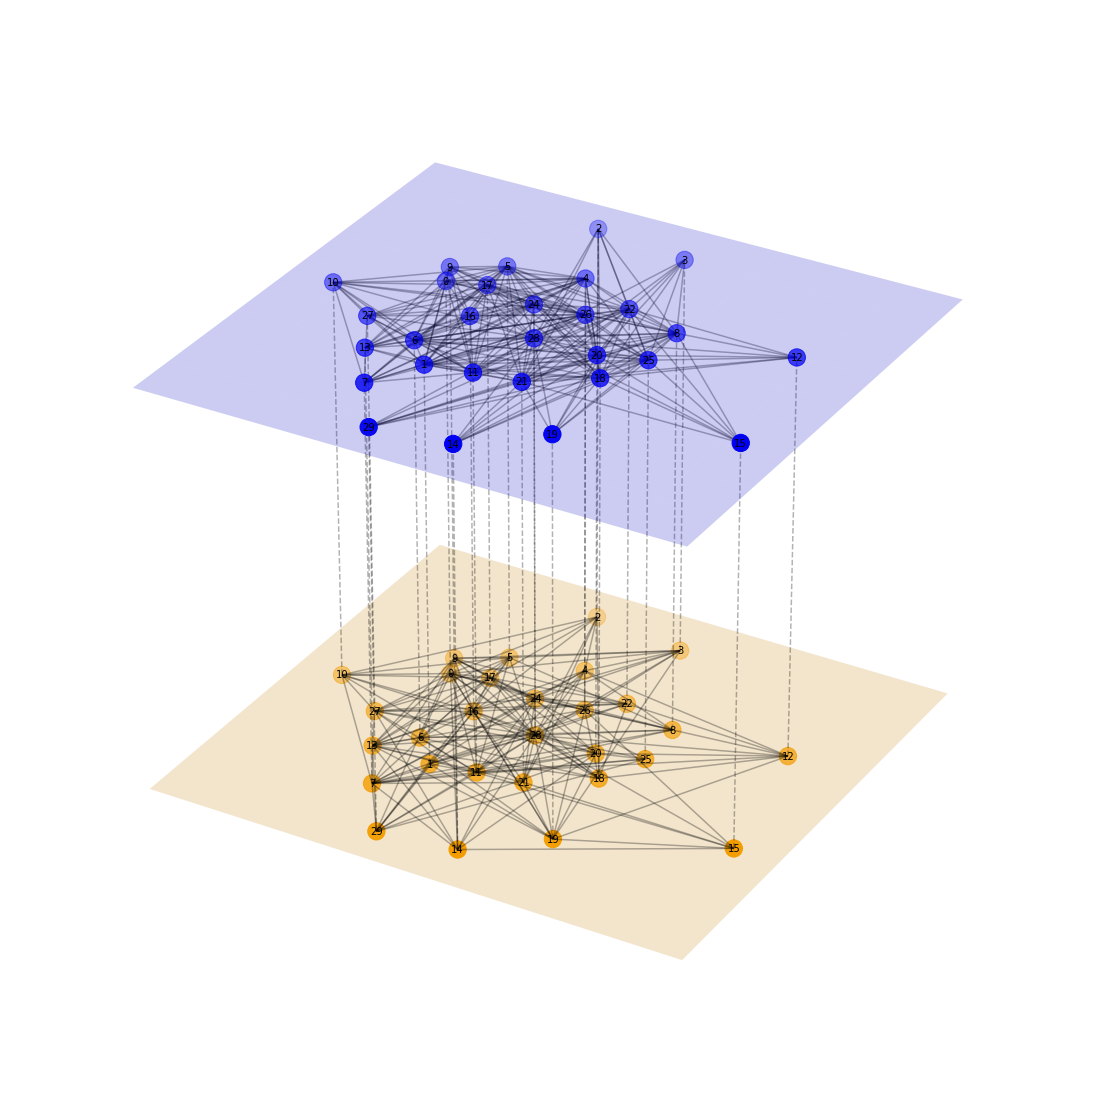

In [29]:
fig = plt.figure(figsize=(36, 20))
ax = fig.add_subplot(111, projection='3d')
node_labels = {nn : str(nn) for nn in range(30)}
LayeredNetworkGraph([model.business, model.social], node_labels=node_labels, ax=ax, layout=nx.spring_layout)
ax.set_axis_off()

plt.show()